In [1]:
import mne
import sys
import os
import importlib

from braindecode.preprocessing.preprocess import preprocess, Preprocessor, zscore
from braindecode.datasets import (create_from_mne_raw, create_from_mne_epochs)
from braindecode.preprocessing.windowers import create_windows_from_events
from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datasets import BaseDataset, BaseConcatDataset, WindowsDataset
from mne_extras import write_edf

from plot import Plot
from segment import Segmenter

import matplotlib.pyplot as plt

from mat73 import loadmat
from tqdm import tqdm

import pprint

pp = pprint.PrettyPrinter(indent=2)


In [ ]:
# data_dir = '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/'
data_dir = '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/'

In [ ]:
files = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]
# subject_files = [os.path.join(files[0], fname) for fname in os.listdir(files[0])]
# recordings = [os.path.join(subjects[0], fname) for fname in os.listdir(subjects[0])]

In [ ]:
files

In [ ]:
def get_file_list(x):
    return [os.path.join(x, fname) for fname in os.listdir(x)]

def get_id(x):
    return x.split('/')[-1]

In [ ]:
annotations = {}
for annotation in get_file_list(data_dir):
    subjects = {}
    for subject in get_file_list(annotation):
        recordings = {}
        for recording in get_file_list(subject):
            dates = {}
            for date in get_file_list(recording):
                for raw_path in get_file_list(date):
                    if '.edf' in get_id(raw_path):
                        break
                    else:
                        pass
                dates[get_id(date)] = raw_path
            recordings[get_id(recording)] = dates
        subjects[get_id(subject)] = recordings
    annotations[get_id(annotation)] = subjects



pp.pprint(annotations)


In [ ]:
import pandas as pd

df = pd.json_normalize(annotations, sep='_').T

# paths list
raw_paths = [df.iloc[i][0] for i in range(len(df))]

# define abnormal and normal subjects
abnormal_subjects = annotations['abnormal'].keys()
normal_subjects = annotations['normal'].keys()

# define descriptions (recoding per subject)
abnormal_descriptions, normal_descriptions, classification = [], [], []
for id in abnormal_subjects:
    for recording in annotations['abnormal'][id].values():
        for x in recording.keys():
            abnormal_descriptions += [{'subject': id, 'recording': x}]
            classification += ['abnormal']
for id in normal_subjects:
    for recording in annotations['normal'][id].values():
        for x in recording.keys():
            normal_descriptions += [{'subject': id, 'recording': x}]
            classification += ['normal']

descriptions = abnormal_descriptions + normal_descriptions

In [ ]:
from sklearn.utils import shuffle
raw_paths, descriptions, classification = shuffle(raw_paths, descriptions, classification)

In [ ]:
# [print(id) for id in abnormal_subjects ]
# [print(x) for x in annotations['abnormal']['072']]

# len(descriptions)
# len(raw_paths)
# len(classification)


In [ ]:

raw = mne.io.read_raw_edf('/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf')

In [ ]:
sfreq = 100
high_cut_hz = 30
low_cut_hz = 0.5
n_jobs = 1

# preprocessing
# for raw in raws:
mne.io.Raw.resample(raw, sfreq)   # resample
mne.io.Raw.filter(raw, l_freq=low_cut_hz, h_freq=high_cut_hz, n_jobs=n_jobs)    # high-pass filter

In [ ]:
raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['abnormal']))

In [ ]:
ssl_sample = mne.io.read_raw_edf('/media/maligan/My Passport/msc_thesis/ssl_thesis/data/sleep_staging_sample/SC4012E0-PSG.edf')
ssl_sample

In [ ]:

# load data and set annotations
dataset = []
for i, path in enumerate(raw_paths):
    # classification = 'abnormal' if  else 'normal'
    print(df.iloc[i].name.split('_')[0])
    
    # raw = mne.io.read_raw_fif(path)
    # raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['abnormal']))
    # dataset.append(raw)


In [ ]:
raw = annotations['abnormal']['021']['00002118']['s006_2013_08_16']
raw = mne.io.read_raw_edf(raw)
# raw.ch_names

In [ ]:
import pandas as pd

df = pd.json_normalize(annotations, sep='_').T
df

In [ ]:
# read, pick channels, save loop
for i in tqdm(range(len(df))):
    file = df.iloc[i][0]
    raw = mne.io.read_raw_edf(file)
    to_export = f"{file.split('/')[-1].split('.')[0]}"
    raw.save(f"{file}_2_channels.fif", picks=['EEG FZ-REF', 'EEG PZ-REF'], overwrite=True)


In [ ]:
# shuffle two arrays the same way

import random

desc

random.seed(90)
random.shuffle(descriptions)
# reset the same seed to get the identical random sequence and shuffle the y
# random.seed(seed)
random.shuffle(y_data)

In [ ]:
pp.pprint(len(normal_descriptions+abnormal_descriptions))
pp.pprint(len(raw_paths))

In [ ]:
# read, pick channels, save loop
for file in tqdm(files):
    raw = mne.io.read_raw_edf('{file}')
    to_export = f"{file.split('/')[-1]}"
    raw.save(f"{data_dir}../eval_2_channels/{to_export}", picks=['Fpz', 'Pz'], overwrite=True)


In [ ]:
data = mat73.loadmat('data/scopolamine/mats/CHDR0511.S2044.10MAY06_0942.O01M01.mat')
biomRegName = loadmat('data/scopolamine/biomRegName.mat')
classification = loadmat('data/scopolamine/ClassificationStatObj.mat')
dataMatrix = loadmat('data/scopolamine/DataMatrixScp1Scp5.mat')
mAChRindex = loadmat('data/scopolamine/mAChRindex.mat')
outcome = loadmat('data/scopolamine/Outcome.mat')

In [ ]:
data['RawSignal']

In [ ]:
mne.io.RawArray(data['RawSignal'], mne.create_info(['Fz-Cz', 'Pz-Oz', '3','4','5','6'], 100))

In [ ]:

print('LOADING BCI DATA')

''' ANNOTATIONS
T0 corresponds to rest
T1 corresponds to onset of motion (real or imagined) of
    the left fist (in runs 3, 4, 7, 8, 11, and 12)
    both fists (in runs 5, 6, 9, 10, 13, and 14)
T2 corresponds to onset of motion (real or imagined) of
    the right fist (in runs 3, 4, 7, 8, 11, and 12)
    both feet (in runs 5, 6, 9, 10, 13, and 14)
'''

subject_size = [1,10]
subjects = range(subject_size[0], subject_size[1]) # max 110
event_codes = [
    1, 2, # eyes open, eyes closed (baselines)
    3, 4, 5,
    6, 7, 8, 9, 
    10, 11, 12, 13, 14
]

physionet_paths, descriptions = [], []

for subject_id in subjects:
    physionet_paths += [mne.datasets.eegbci.load_data(subject_id, event_codes, update_path=False)]
    descriptions += [{"event_code": code, "subject": subject_id} for code in event_codes]


In [ ]:
# raw_set = [
#     '/home/maligan/mne_data/physionet-sleep-data/SC4012E0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4451F0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4441E0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4431E0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4421E0-PSG.edf',
# ]

# space_bambi directory
data_dir = './data/SPACE_BAMBI_2channels/'
raw_set = [
    f'{data_dir}SPACE.S175.yyyymmdd.EORASD_raw.fif',
    f'{data_dir}SPACE.S170.yyyymmdd.EORASD_raw.fif'
]

print(raw_set)

# load into raw array
raws = [mne.io.read_raw_fif(x, preload=True) for x in raw_set]

In [ ]:
# space_bambi directory
data_dir = './data/SPACE_BAMBI_2channels/'

raws = []

print(f'{len(os.listdir(data_dir))} files found')
for i, path in enumerate(os.listdir(data_dir)):
    if i == 5:
        break
    full_path = os.path.join(data_dir, path)
    raws.append(mne.io.read_raw_fif(full_path, preload=True))

In [ ]:
# import pandas as pd
# descriptions = []

# for id, raw in enumerate(raws):
#     descriptions += [{
#         id: {
#         "onset": annot['onset'], 
#         "duration": annot['duration'], 
#         "description": annot['description'], 
#         "orig_time": annot['orig_time']
#         }
#     } for annot in raw.annotations]

In [ ]:
descriptions = []

for subject_id, raw in enumerate(raws):
    descriptions += [{"subject": subject_id}]

In [ ]:
descriptions[0]

In [ ]:
raws[0].ch_names

In [ ]:

event_codes = [
    1, 2, # eyes open, eyes closed (baselines)
    3, 4, 5,
    6, 7, 8, 9, 
    10, 11, 12, 13, 14
]

physionet_paths, descriptions = [], []

for subject_id in subjects:
    physionet_paths += [mne.datasets.eegbci.load_data(subject_id, event_codes, update_path=False)]
    descriptions += [{"event_code": code, "subject": subject_id} for code in event_codes]


In [ ]:
descriptions

In [ ]:
### preprocess
# resample to 160Hz
# high pass filtering of 30Hz

sfreq = 160
high_cut_hz = 30
n_jobs = 2

for raw in raws:
    mne.io.Raw.resample(raw, sfreq, n_jobs=n_jobs) # resample all files
    mne.io.Raw.filter(raw, l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs) # high-pass filter

In [ ]:
base_datasets = [BaseDataset(raw) for raw in raws]
base_concat_datasets = BaseConcatDataset(base_datasets)

In [ ]:
base_concat_datasets

In [ ]:
window_size_samples = 100

windows_dataset = create_from_mne_raw(
    raws,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    drop_last_window=True,
    # descriptions=descriptions,
    accepted_bads_ratio=0.5,
    drop_bad_windows=True,
    # mapping=mapping,
    # preload=True,
    on_missing='ignore'
)


In [ ]:
type(windows_dataset)

In [ ]:
# z-score normalization

preprocess(windows_dataset, Preprocessor(zscore))


In [ ]:
path = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/SPACE_BAMBI_2channels/SPACE.S170.yyyymmdd.EORASD_raw.fif'

raw = mne.io.read_raw_fif(path)
raw

In [ ]:
importlib.reload(sys.modules['segment'])

In [ ]:
segmenter = Segmenter()
raw = mne.io.read_raw_fif('/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/SPACE_BAMBI_2channels/SPACE.S175.yyyymmdd.EORASD_raw.fif')

In [ ]:
mapped_segments = segmenter.segment(raw)

In [ ]:
raw.info

In [ ]:
raw.annotations

In [ ]:
# Print results
ids = [e[2] for e in mapped_segments.events]  # all ids
idx_ignore = [id for id, id_ in enumerate(ids) if id_ == 2]  # ids of segments to ignore
idx_artifacts = [id for id, id_ in enumerate(ids) if id_ == 0]  # ids of artifact segments
idx_nonartifacts = [id for id, id_ in enumerate(ids) if id_ == 1]  # ids of nonartifact segments
print('Number of artifact segments is {}'.format(len(idx_artifacts)))
print('Number of non-artifact segments is {}'.format(len(idx_nonartifacts)))
print('Number of segments to ignore is {}'.format(len(idx_ignore)))

In [ ]:
import pathlib

dir_path = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/mats/raws/"

mats = os.listdir(dir_path)
mats

In [ ]:
from  mat73 import loadmat
import mne

raws = []
info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)

for mat in mats:
    print(mat)
    # select columns 3 and 4 (Fpz-Cz, and Pz-Oz respectively) and convert to microvolts
    x = loadmat(dir_path + mat)['RawSignal'][:, [2,3]].T / 100000
    raw = mne.io.RawArray(x, info)
    raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['scopolamine']))

raws

In [ ]:
info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)
raw = mne.io.RawArray(dataset[0], info)
# raw.plot()

In [ ]:
from  mat73 import loadmat
import mne

print(':: loading SCOPOLAMINE data')

scop_dir = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/mats/raws/'

mats = os.listdir(scop_dir)

scp_raws, scp_desc = [], []
info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)

# creating scopolamine raw data
for i, mat in enumerate(mats):
    print(mat)
    # select columns 3 and 4 (Fpz-Cz, and Pz-Oz respectively) and convert to microvolts
    x = loadmat(scop_dir + mat)['RawSignal'][:, [2,3]].T / 100000
    raw = mne.io.RawArray(x, info)
    scp_raws += [raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['scopolamine']))]
    scp_desc += [{'subject': 1, 'recording': i}]

# creating sample abnormal raw data
# ----------------------------- TEMP -------------------------------------------------

abn_dir = [
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf_2_channels.fif',
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/011/00001154/s007_2012_07_25/00001154_s007_t000.edf_2_channels.fif'
]
norm_dir = [
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/normal/006/00000647/s002_2009_09_21/00000647_s002_t000.edf_2_channels.fif',
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/normal/013/00001355/s003_2009_12_08/00001355_s003_t000.edf_2_channels.fif'
]


# only 1 rec per subject (temporary)
def make_raws(_class, dataset=[], descriptions=[]):
    for i, path in enumerate(abn_dir):
        raw = mne.io.read_raw_fif(path)
        raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=[_class]))
        dataset.append(raw)
        descriptions += [{'subject': len(descriptions)+1, 'recording': 1}]

    return dataset, descriptions
    
dataset, descriptions = make_raws('abnormal')
dataset, descriptions = make_raws('normal', dataset, descriptions)

dataset += scp_raws
descriptions += scp_desc

# -----------------------------------------------------------------------------------

for i, x in enumerate(dataset):
    print(dataset[i], descriptions[i])



In [ ]:
#  generate signal
import numpy as np
from matplotlib import pyplot as plt

from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)
from mne.viz import centers_to_edges

sfreq = 100.0
ch_names = ['SIM0001', 'SIM0002']
ch_types = ['eeg'] *2
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

n_times = 1024  # Just over 1 second epochs
n_epochs = 40
seed = 42
rng = np.random.RandomState(seed)
noise = rng.randn(n_epochs, len(ch_names), n_times)

# Add a 50 Hz sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
on_time = np.logical_and(t >= 0.45, t <= 0.55)
signal[on_time] *= np.hanning(on_time.sum())  # Ramping
data = noise + signal

reject = dict(eeg=4000)
events = np.empty((n_epochs, 3), dtype=int)
first_event_sample = 100
event_id = dict(sin50hz=1)
for k in range(n_epochs):
    events[k, :] = first_event_sample + k * n_times, 0, event_id['sin50hz']

epochs = EpochsArray(data=data, info=info, events=events, event_id=event_id,
                     reject=reject)


epochs.average().plot()


In [ ]:
ch_names = ['SIM0001', 'SIM0002']
ch_types = ['eeg'] *2
sfreq = 100.0
n_times = 1024

info = mne.create_info(ch_names, sfreq, ch_types=['eeg'] *2)

In [ ]:
raw.plot()



In [ ]:
ch_names=['SIM0001', 'SIM0002']
ch_types=['eeg']*2
sfreq=100.0
n_times=5000
seed=42
wave_hz=50.0
stage='noise'

rng = np.random.RandomState(seed)
noise = rng.randn(len(ch_names), n_times)

# Add a specified (50hz) sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2. * wave_hz * t)  # wave_hz sinusoid signal
signal[np.logical_or(t < wave_hz-0.5, t > wave_hz+0.5)] = 0.  # Hard windowing
on_time = np.logical_and(t >= wave_hz-0.5, t <= wave_hz+0.5)
signal[on_time] *= np.hanning(on_time.sum())  # Ramping
data = noise + signal

info = mne.create_info(ch_names, sfreq, ch_types)
raw = mne.io.RawArray(data/100000, info)
raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=[stage]))

In [ ]:
points = raw[:][0][:][0]

# %matplotlib inline

fig, ax = plt.subplots(1,1)
plt.hist(points)
plt.show()

In [ ]:
ch_names=['SIM0001', 'SIM0002']
ch_types=['eeg']*2
sfreq=100.0
n_times=5000
seed=42
wave_hz=50.0
stage='white_noise'
bound=1

noise = np.array([
    np.random.uniform(wave_hz-bound, wave_hz+bound, size=n_times), 
    np.random.uniform(wave_hz-bound, wave_hz+bound, size=n_times)
])

# Add a specified (50hz) sinusoidal burst to the noise and ramp it.
# t = np.arange(n_times, dtype=np.float64) / sfreq
# signal = np.sin(np.pi * 2. * wave_hz * t)  # wave_hz sinusoid signal
# signal[np.logical_or(t < wave_hz-0.5, t > wave_hz+0.5)] = 0.  # Hard windowing
# on_time = np.logical_and(t >= wave_hz-0.5, t <= wave_hz+0.5)
# signal[on_time] *= np.hanning(on_time.sum())  # Ramping
# data = noise + signal

info = mne.create_info(ch_names, sfreq, ch_types)
white_noise = mne.io.RawArray(noise/100000, info)
white_noise = white_noise.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=[stage]))

In [ ]:
white_noise.plot()

In [ ]:
points = white_noise[:][0][:][0]

# %matplotlib inline

fig, ax = plt.subplots(1,1)
plt.hist(points)
plt.show()

In [ ]:
white_noise[:][0][:][0]

In [ ]:
from matplotlib import cm

n_stages = 2 
colors = cm.get_cmap('viridis', n_stages)(range(n_stages))

In [ ]:
type(white_noise[0][0])

In [ ]:
from obspy.signal.tf_misfit import plot_tfr
import numpy as np

In [ ]:
arr = np.random.randn(50)
print(arr.shape, len(arr))
print(np.max(arr), np.min(arr))

In [ ]:
from mne.time_frequency import tfr_morlet

tfr_morlet(arr)

In [ ]:
import matplotlib.pyplot as plt
from obspy import read

st = read()
tr = st[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(tr.times("matplotlib"), tr.data, "b-")
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

In [ ]:
%matplotlib

fig, ax = plt.subplots(1,2)

ax = plot_tfr(arr, dt=0.1, h_2=2, w_2=2, show=False)


## TF plots for scopolamine - visual inspection

In [ ]:
%matplotlib inline

m01 = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/CHDR0507.S1001.06MAR06_0911.O04M01.mat'
m05 = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/CHDR0507.S1001.06MAR06_1237.O04M05.mat'

info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)

In [ ]:
# scopolamine - M01
m01_raw = mne.io.RawArray((loadmat(m01)['RawSignal'][:, [2,3]].T / 100000), info)
m01_cropped = m01_raw.crop(0, 20)

In [ ]:
raw = m01_raw

raw.plot()

In [ ]:
raw = raw.filter(l_freq=0.5, h_freq=30, n_jobs=1)
raw = raw.resample(100)

In [ ]:
raw.plot()

In [ ]:
# scopolamine - M05
m05_raw = mne.io.RawArray((loadmat(m05)['RawSignal'][:, [2,3]].T / 100000), info)
m05_cropped = m05_raw.crop(0, 20)

In [ ]:
# m05_cropped.plot()

In [ ]:
# Fpz_Cz
plot_tfr(m01_cropped[:][0][0], dt=0.1, h_2=2, w_2=2)
plot_tfr(m05_cropped[:][0][0], dt=0.1, h_2=2, w_2=2)

In [ ]:
# Pz_Oz

fig, (ax1,ax2) = plt.subplots(1, 2)

ax = plot_tfr(m01_cropped[:][0][1], dt=0.1, h_2=2, w_2=2, fmax=1, show=False)
# plot_tfr(m05_cropped[:][0][1], dt=0.1, h_2=2, w_2=2, fmax=0.001)
plt.show()

## Logistic regression for fully-supervised data

In [143]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve, cross_validate

from sklearn.datasets import load_iris, load_breast_cancer

import numpy as np

In [135]:

pipeline = make_pipeline(
    # StandardScaler(),
    LogisticRegression(
        penalty='l2', C=1.0, class_weight='balanced', solver='newton-cg',
        multi_class='multinomial', random_state=42
    )
)

In [136]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [146]:
# training
train_sizes, train_scores, valid_scores, fit_times, score_times = learning_curve(
    pipeline,
    X, y,
    cv=5,
    train_sizes=np.linspace(0.1, 1, 10),
    return_times=True
)

/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceW

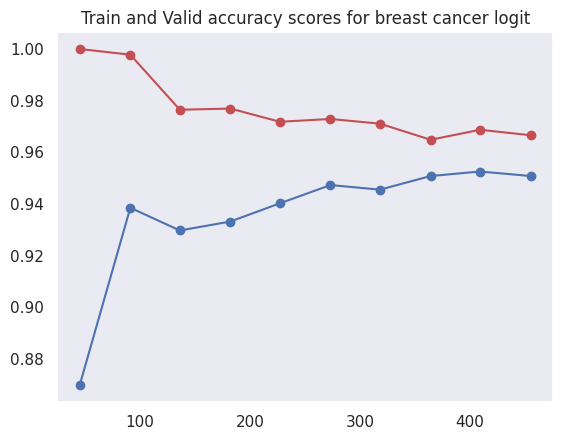

In [147]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.grid()
plt.title('Train and Valid accuracy scores for breast cancer logit')
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, "o-", color="b", label="Validation score")
plt.show()

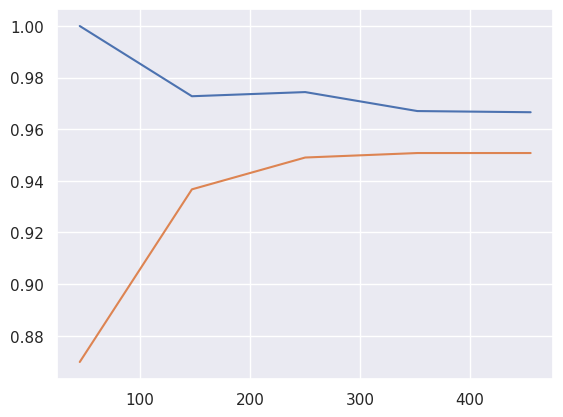

In [140]:
# seaborn
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x=train_sizes, y=train_scores_mean,
            #  hue="region", style="event"
             )
sns.lineplot(x=train_sizes, y=valid_scores_mean,
            #  hue="region", style="event"
             )
plt.show()

In [142]:

print(f'predicting: {pipeline.predict(X)}')
print(f'predicting prob: {pipeline.predict_proba(X[-1:, :])}')
print(f'score: {pipeline.score(X,y)}')

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## EEG windows

In [154]:
array = np.array([
    [splitted['train'][i][0][0] for i in range(len(splitted['train']))],
    [splitted['train'][i][1][0] for i in range(len(splitted['train']))]
])

NameError: name 'splitted' is not defined

In [156]:
np.array([[1],[2]])


array([[1],
       [2]])